In [1]:
pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=55ae1f9ca4fdbb027df373a8b63f196c9b72e2ff2b7c5dbf17089c459329bc1b
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [2]:
# imports from the islp lab
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestClassifier as RF,
      GradientBoostingClassifier as GBR)


In [3]:
data = pd.read_csv("full_dataset.csv")


Using the decision tree classifier to predict winner 2020 without proportions but with states included.

In [4]:
# one hot encoding state
data = pd.get_dummies(data, prefix=["State"], columns=["State"], drop_first=True)


In [5]:
# setup for making a model
model = MS(data.columns.drop(['County','county_fips', 'prop_favored_dem_2020','winner_2020','county_names_with_casing','prop_favored_dem_2016',
       'prop_favored_dem_2012', 'prop_favored_dem_2008',
       'prop_favored_dem_2004', 'prop_favored_dem_2000', 'total_votes_2020', 'total_votes_2016',
       'total_votes_2012', 'total_votes_2008', 'total_votes_2004',
       'total_votes_2000']), intercept=False)
D = model.fit_transform(data)
feature_names = list(D.columns)
winner = data[["winner_2020"]].values.ravel()
X = np.asarray(D)

In [6]:
# make a train test split
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                                   winner,
                                   test_size=0.2,
                                   random_state=0)

In [7]:
# no max depth is given, as that is found through cross validation
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.8964968152866242

test accuracy of 89% without pruning without election results

In [8]:
# making a tree with pruning
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and $\alpha$
 values from which we can extract an optimal one by cross-validation.

In [9]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.9198597609561752

While train accuracy didn't go down that much, it still seems incredibly high for a basic model.

Anyways, the basic model is:

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_export.py:670: UserWarning: Glyph 9 (	) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


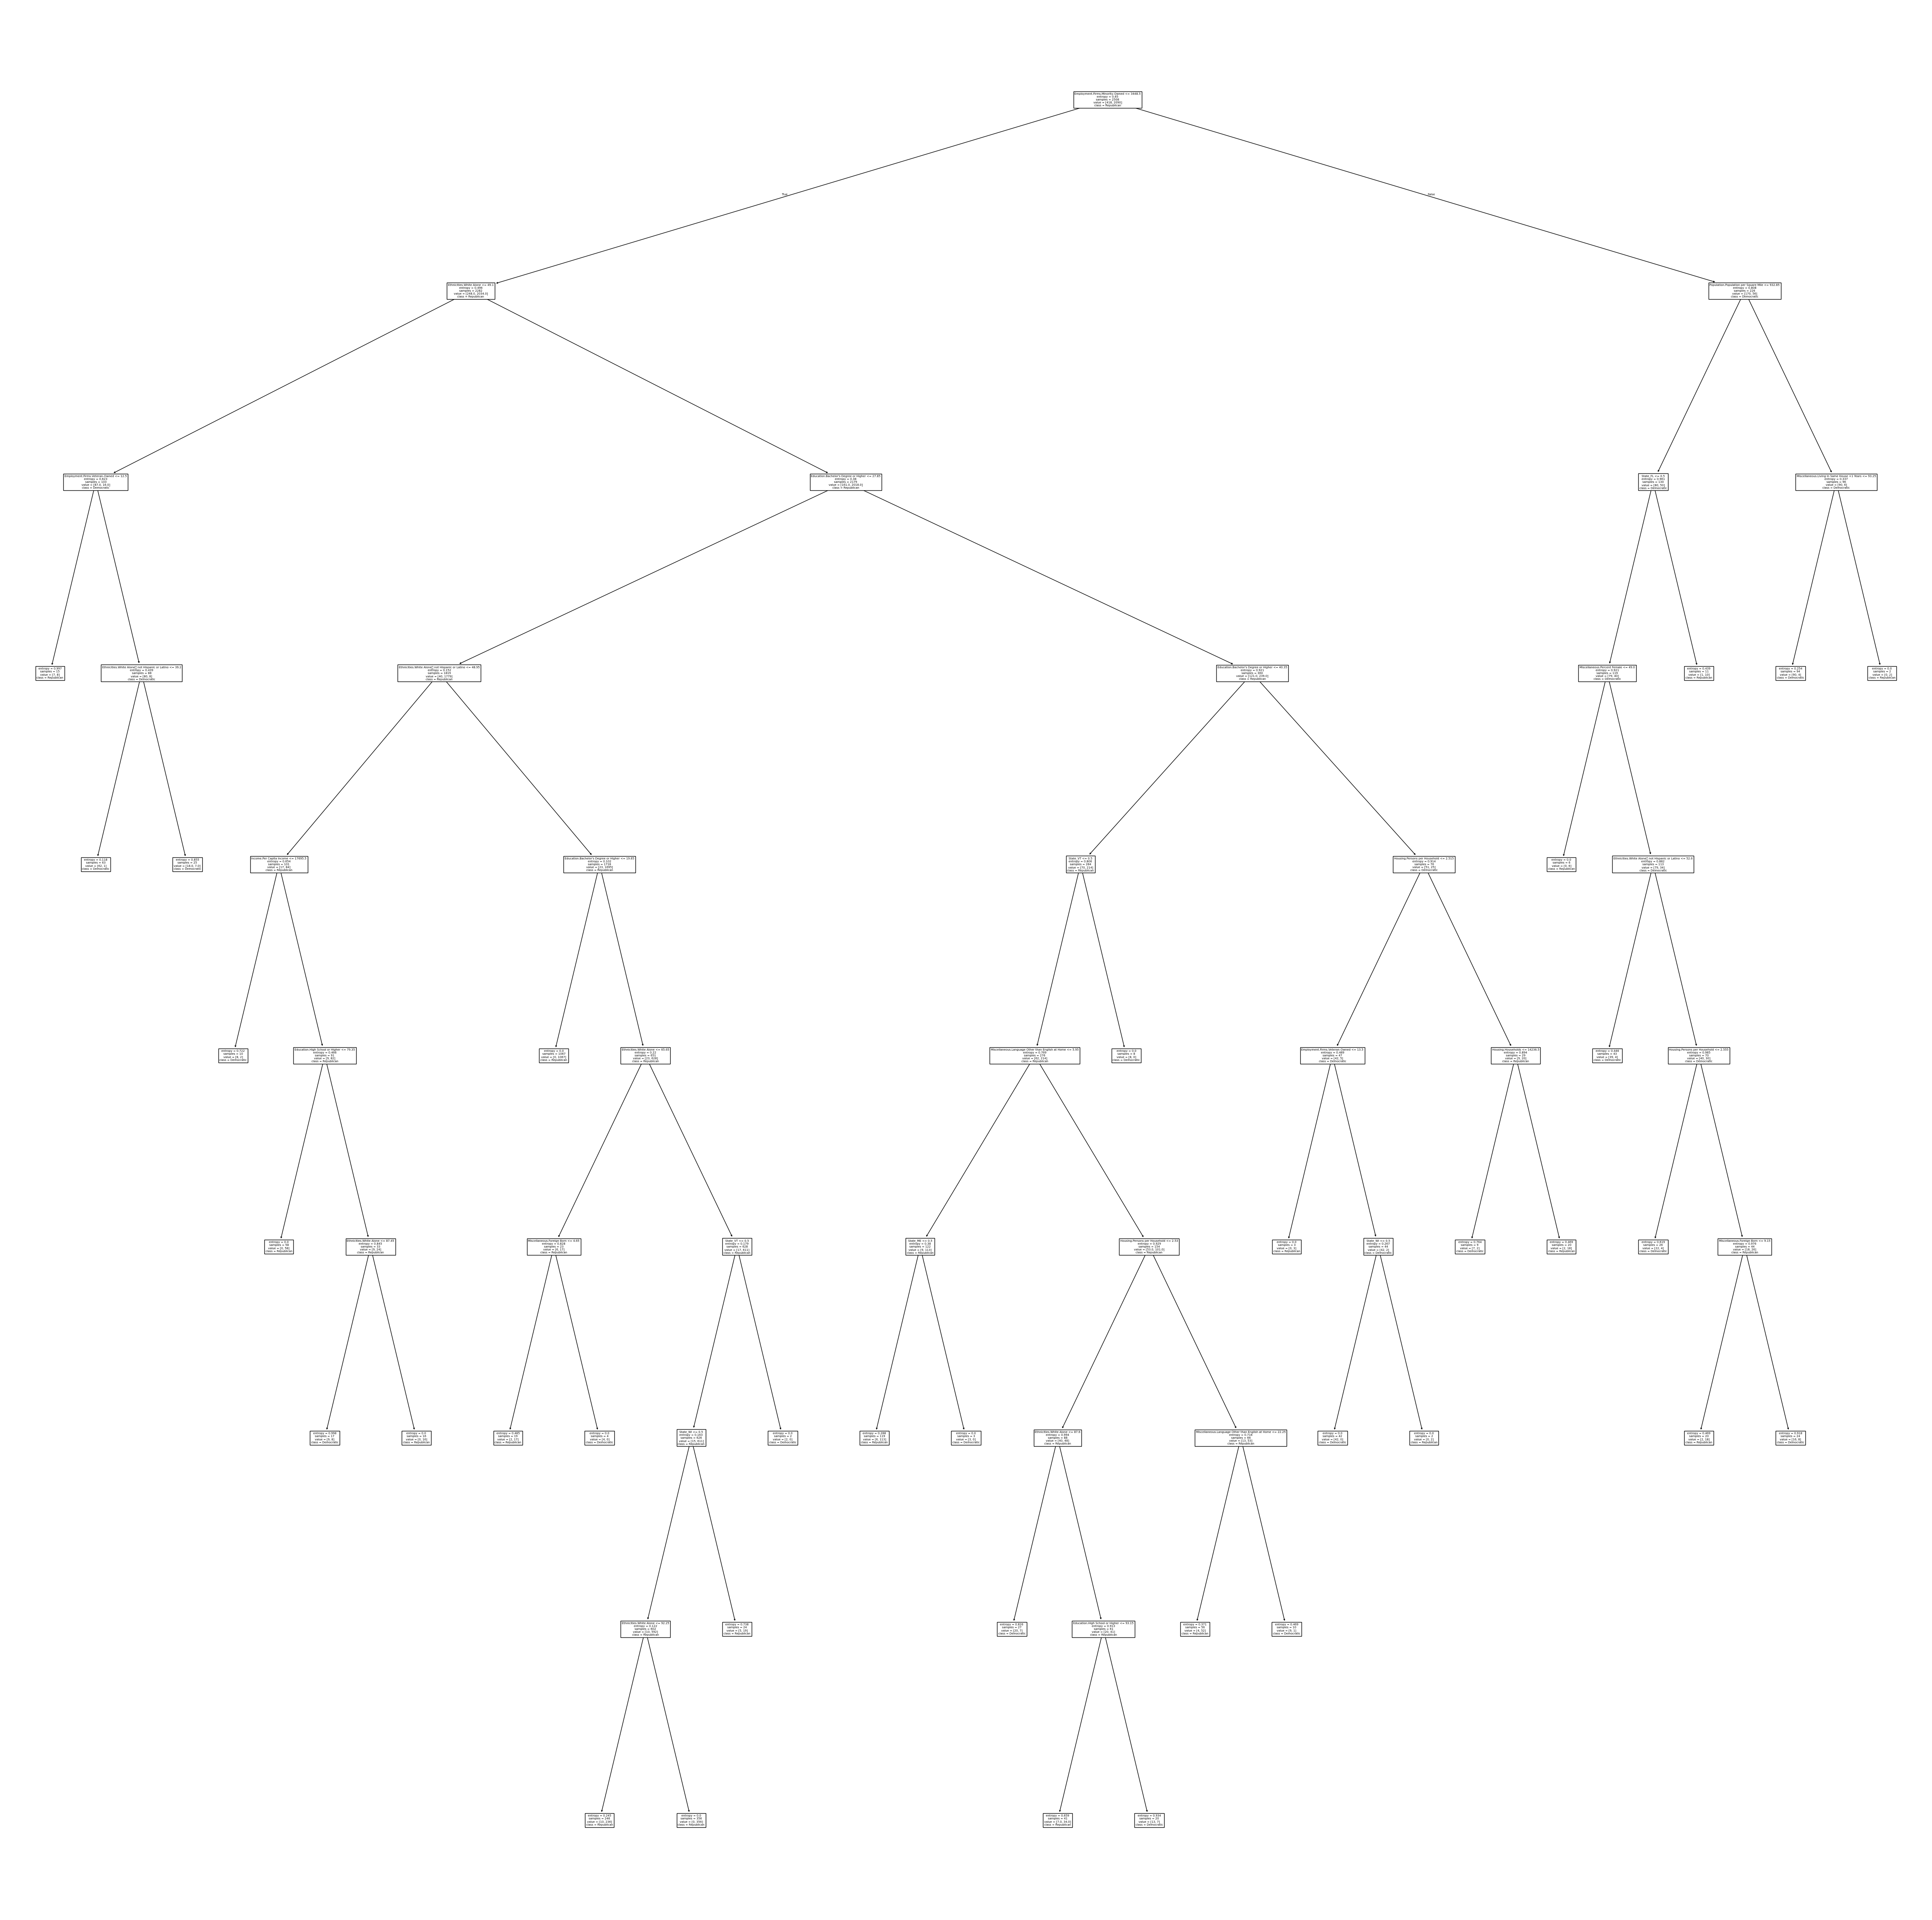

In [10]:
ax = subplots(figsize=(60, 60))[1] # the figsize needs to be increased to make them readable
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax, class_names = ["Democratic","Republican"]);


In [11]:
print(export_text(best_,
                  feature_names=feature_names,
                  show_weights=True))

|--- Employment.Firms.Minority-Owned <= 3448.50
|   |--- Ethnicities.White Alone <= 49.10
|   |   |--- Employment.Firms.Veteran-Owned <= 12.50
|   |   |   |--- weights: [7.00, 8.00] class: Republican
|   |   |--- Employment.Firms.Veteran-Owned >  12.50
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 39.20
|   |   |   |   |--- weights: [62.00, 1.00] class: Democrat
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino >  39.20
|   |   |   |   |--- weights: [18.00, 7.00] class: Democrat
|   |--- Ethnicities.White Alone >  49.10
|   |   |--- Education.Bachelor's Degree or Higher <= 27.85
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 48.95
|   |   |   |   |--- Income.Per Capita Income <= 17695.50
|   |   |   |   |   |--- weights: [8.00, 2.00] class: Democrat
|   |   |   |   |--- Income.Per Capita Income >  17695.50
|   |   |   |   |   |--- Education.High School or Higher <= 79.35
|   |   |   |   |   |   |--- weights: [0.00, 58.00] class:

In [12]:
best_.tree_.n_leaves


35

Having states involved creates large trees.

In [13]:
# on test data
print(accuracy_score(y_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            y_test)
confusion

0.9092356687898089


Truth,Democrat,Republican
Predicted,,
Democrat,96,23
Republican,34,475


correct 73.8% of the time on democrat counties, 95.4% of the time on republican counties. Pruning seemed to improve the test error of the model.

Random forest

In [20]:
forest = RF(random_state=0).fit(X_train, y_train)
y_hat_RF = forest.predict(X_test)
np.sum(y_test == y_hat_RF) / len(y_test)

0.9171974522292994

In [21]:
feature_imp = pd.DataFrame(
    {'importance':forest.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Ethnicities.White Alone,0.094753
Ethnicities.White Alone\t not Hispanic or Latino,0.089725
Education.Bachelor's Degree or Higher,0.080287
Employment.Firms.Minority-Owned,0.063410
Population.Population per Square Mile,0.051291
...,...
State_AR,0.000104
State_CT,0.000083
State_NV,0.000047
State_WV,0.000023


In [23]:
confusion_table(y_hat_RF, y_test)

Truth,Democrat,Republican
Predicted,,
Democrat,88,10
Republican,42,488


Interestingly, unlike the normal decision trees, random forest performs better without states, as with states its accuracy decreases on this train test split (this can be seen by looking at the file for without proportions and without states)

While the random forest model has a higher test accuracy than the pruned tree overall, it is more accurate on republican counties, and less accurate on democrat ones, meaning that it is just picking republican counties more often, of which there happen to be more of in our dataset.